#Problem#1 : Bangla Hand Written Digit Recognizer
Appling only **logistic** regression for the **NumtaDB** dataset and building a **multiclass** classification model that can recognize [0-9] Bengali handwritten digits with different hyperparameter settings.

##Logistic Regression for multiclass classification:
**Logistic** regression is a very popular machine learning technique. Logistic regression is used when the dependent variable is categorical.
The **goal** of logistic regression is to minimize the error between its
predictions and training data. 
if given x feature vector,

$\;\;\;Y=P(y=1|x), \;where\; 0<=Y<=1$

Logistic regression uses a **sigmoid** function to predict the output. The sigmoid function returns a value from 0 to 1.

$\;\;\;s=\sigma (w^Tx+b)=\sigma(z)=\frac{1}{1+e^{-z}}$

The implementation of **Multiclass** classification follows the same ideas as the binary classification.In multi-class classification, we have more than two classes. 

For multiple classes, logistic regression uses a **softmax** function to predict the output. Applying the softmax function, it gives an array of result. These represent the probability for the data point belonging to each class. The sum of all the values in the result array is 1.


$\;\;\;a_i=\frac{e^{z_i}}{\sum^c_{k=1}   e^{-z_k}}$
$\;\;\;where \sum^c_{i=1} a_i =1 $

Here, we are implementing Bangla Handwritten Digit Recognizer using logistic regression.For this, we need image as input and we have 10 classes(0-9) as output. So, we are implementig multi-class classification.

##Dataset: 
One of the key topics of NLP is optical character recognition (OCR). To build an OCR in Bengali language, digit classification provides a convenient starting point. **NumtaDB** s a large dataset (85,000+) of Bengali digits which can be used by researchers for benchmarking their algorithm.

<div align="center">
<img src="https://drive.google.com/uc?id=1LvkNwV1My2RniR_JsbasBET1fa97eMQu" width="500">
</div>

- **input dimension:**
  - Size of an image: $28 \times 28 = 744$
- **output dimension: 10**
  - 0,1,2,3,4,5,6,7,8,9


The steps to implement bangla hand written digit recognizer will be the following:

##Step#1: Load the dataset
The NumtaDb dataset is directly loaded from Kaggle. 

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anikatanzimaboni","key":"13fc7f14dc7fd8e9f087e64c6b2a14f2"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json # changing permission

In [ ]:
!kaggle datasets download -d BengaliAI/numta

100% 1.91G/1.91G [00:18<00:00, 37.4MB/s]
100% 1.91G/1.91G [00:19<00:00, 107MB/s] 


**numta.zip** file is downloaded from Kaggle directly. After unzipping it, we get the actual dataset.

In [ ]:
from zipfile import ZipFile
f_name= 'numta.zip'
with ZipFile(f_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import os
from os import path
import shutil

In the dataset, the sources are labeled from 'a' to 'e'. The training sets have separate subsets depending on the source of the data (training-a, training-b, etc.) and the details are also in different csv files (training-a.csv, training-b.csv, etc.)

In [ ]:
def showRawTrainingSamples(csv_filename):
  df = pd.read_csv(csv_filename)
  print(csv_filename)
  print(df.columns)
  return df

In [ ]:
import pandas as pd
a_csv = showRawTrainingSamples('training-a.csv')
b_csv = showRawTrainingSamples('training-b.csv')
c_csv = showRawTrainingSamples('training-c.csv')
d_csv = showRawTrainingSamples('training-d.csv')
e_csv = showRawTrainingSamples('training-e.csv')

training-a.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')
training-b.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')
training-c.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')
training-d.csv
Index(['original filename', 'scanid', 'digit', 'num', 'database name original',
       'database name', 'filename'],
      dtype='object')
training-e.csv
Index(['filename', 'original filename', 'districtid', 'institutionid',
       'gender', 'age', 'datestamp', 'scanid', 'digit',
       'database name original', 'database name'],
      dtype='object')


From the csv files, we only need the information of the file names and their labels which column names are '**filename**' and '**digit**' respectively. So we truncate the data.

In [ ]:
def truncateColumns(csv_file):
  csv_file = csv_file[['filename', 'digit']]
  print('Done')
  return csv_file

In [ ]:
a_csv = truncateColumns(a_csv)
b_csv = truncateColumns(b_csv)
c_csv = truncateColumns(c_csv)
d_csv = truncateColumns(d_csv)
e_csv = truncateColumns(e_csv)

Done
Done
Done
Done
Done


All the csv files are merged into one for further process. So, in total, there are 72045 data for training and testing the model.

In [ ]:
total_csv = [a_csv,b_csv,c_csv,d_csv,e_csv]
merged_csv = pd.concat(total_csv)
print(len(merged_csv))

72045


Similarly, all  the images from different directory are merged into one directory named "**trainAll2**".

In [ ]:
TRAIN_PATH = 'trainALL2'
os.mkdir(TRAIN_PATH) #creating the directory

def processImages(folder_name):
  src = folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) #images are copied to trainAll2


In [ ]:

processImages('training-a')
print('A Done')
processImages('training-c')
print('C Done')
processImages('training-d')
print('D Done')

A Done
C Done
D Done


In [ ]:
processImages('training-b')
print('B Done')
processImages('training-e')
print('E Done')

B Done
E Done


##Step#2: Prepare (augment) the dataset
The loaded dataset is still non trival. PyTorch provides many tools to make data loading easy and hopefully, to make the code more readable. 


In [ ]:
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

###Custom Dataset Class

**`torch.utils.data.Dataset`** is an abstract class representing a dataset. To prepare the dataset, we need a** custom Dataset Class**. Our custom dataset should inherit Dataset and override the following methods:

- **`__len__`** so that len(dataset) returns the size of our dataset.

- **`__getitem__`** to support the indexing such that dataset[i] can be used to get ith sample. 
We will read the csv in` __init__` but leave the reading of images to `__getitem__`.


In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform

        """
            df : Path to the csv file with annotations.
            root : Directory with all the images.
            transform : Optional transform to be appliedon a sample.
        """
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

###Compose Transforms
The samples are not of the same size. Our model expect the images of a fixed size. `torchvision.transforms.Compose` is a simple callable class which allows us to do this.

- **Resize((28,28))** resize/crop the image to 28*28 dimension
- **ToTensor()** takes a PIL image (or np.int8 NumPy array) with shape (n_rows, n_cols, n_channels) as input and returns a PyTorch tensor with floats between 0 and 1 and shape (n_channels, n_rows, n_cols).
- **Normalize(mean,std)** subtracts the mean and divides by the standard deviation of the floating point values in the range [0, 1].
- As mean =0.5 and std =0.5, an image is normalized to [-1,1] here.

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

'''Instantiate the Dataset Class'''
train_dataset  = Dataset(merged_csv, TRAIN_PATH, train_transform)
test_dataset = Dataset(merged_csv, TRAIN_PATH, test_transform)

print("Trainig Samples: ",len(train_dataset))

Trainig Samples:  72045


##step#3 : Make Data Iterable
- We split the training set to 90% and test set to 10%. That means a 90:10 ratio. To split the data we have used **`torch.utils.data.sampler`** class.
- We will use the **DataLoader** class to make our dataset iterable. 

In [ ]:
import numpy as np
#batch size
#batch_size = 100
batch_size = 64
#batch_size = 32 
#batch_size=45
# split data 10% for testing
test_size = 0.1

# obtain training indices that will be used for validation
len_train = len(train_dataset)

# mix data
# index of num of train
indices = list(range(len_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * len_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size,
    sampler=train_sampler) #No need to shuffle here, because sampler has shuffled data already

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:1014
Test dataloader:113


Showing the information of one sample data and the images:

In [ ]:
'''Informations of one sample data'''
# One Image Size
print(train_dataset[22][0].size())
print(train_dataset[22][0].numpy().shape)
# First Image Label
print(train_dataset[22][1])

torch.Size([1, 28, 28])
(1, 28, 28)
6


In [ ]:
import matplotlib.pyplot as plt 
import numpy as np

print("Label:")
print(train_dataset[0][1])
show_img = train_dataset[0][0].numpy().reshape(28, 28)
plt.imshow(show_img, cmap='gray')

In [ ]:
print("Label:")
print(train_dataset[201][1])

show_img = train_dataset[201][0].numpy().reshape(28, 28)
plt.imshow(show_img, cmap='gray')

##Step#4: Create the Model Class

In order to set up the model class, we need to initialize the model type and declare the forward pass. 

We initialize our model with this linear layer: **`torch.nn.Linear(input_size, num_classes)`** which
applies a linear transformation to the incoming data:  $y=W^T∗x+b$.

Parameters:

- input_size – size of each input sample (i.e. size of x)
- num_classes – size of each output sample (i.e. size of y)
- bias – If set to False, the layer will not learn an additive bias. Default: True

Next is to define the forward pass function. The forward pass refers to the calculation process of the output data from the input. The function takes x as its input and outputs the logits. 

We can simply apply **`functional.softmax`** to our current linear output from the forward pass: **`probas = functional.softmax(logits,dim=1)`**. Probas will be the predicted Y.

Softmax is used because it is a multi class classification for logistic regression.

The complete model class is defined below:

In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        """
          In the forward function we accept a Variable of input data and we must return
          a Variable of output data. We can use Modules defined in the constructor as
          well as arbitrary operators on Variables.
        """
    def forward(self, x):
        logits  = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

##Step#5:Instantiate the Model Class

####**Modelparameter:**
Model parameters are learned during training when we optimize a loss function using something like gradient descent.

####**Hyperparameter:**
Parameters which define the model architecture are referred to as hyperparameters. Hyperparameters are not model parameters and they cannot be directly trained from the data. 
These values are fixed before the training of the data begins. They deal with parameters such as learning_rate,num_iters etc.

- **learning_rate**: How quickly the model should be able to learn, how complicated the model is, and so on. 
- **num_iters**: It is used to specify the number of combinations that are randomly tried. If num_iters is too less, finding the best combination is difficult, and if num_iters is too large, the processing time increases. It is important to find a balanced value for ‘n_iter’.
  - **1 iteration**: One mini-batch forward & backward pass. That means a parameter (wights and biases) update. 
- **minibatch**:  Number of examples in 1 iteration
- **epochs**: How many times we are running the dataset

  - **1 epoch**: Running through the whole dataset once

Before instantiation, we’ll initialize some hyperparameters like following.

In [ ]:
# Hyperparameters

batch_size = 45
num_iters = 16010      #to get 10 epoch, per batch there is 1601 data
input_dim = 28*28      # num_features = 784
output_dim = 10

learning_rate = 0.001
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Instantiating the model class and enabling GPU:

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

##Step#6: Construct loss and optimizer (select from PyTorch API)

We need Cross Entropy Loss to calculate our loss before we backpropagate and update our parameters.

`criterion = nn.CrossEntropyLoss() ` 

It does 2 things at the same time.

1. Computes softmax **([Logistic or Sigmoid]/softmax function)**
2. Computes Cross Entropy Loss

In [ ]:
# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

##Step #7 : Training: forward, loss, backward, step




  




- Calling `.backward()` mutiple times accumulates the gradient (**by addition**) for each parameter. 

- This is why you should call `optimizer.zero_grad()` after each .step() call. 

- Note that following the first `.backward` call, a second call is only possible after you have performed another **forward pass**.

- `optimizer.step` performs a parameter update based on the current gradient (**stored in .grad attribute of a parameter**)

Simplified equation:

- `parameters = parameters - learning_rate * parameters_gradients`
- parameters $W$ and $b$ in ($y = W^T * x + b$)
- $\theta = \theta - \eta \cdot \nabla_\theta$  [ General parameter $\theta$ ]
  *  $\theta$ : parameters (our variables)
  *  $\eta$ : learning rate (how fast we want to learn)
  *  $\nabla_\theta$ : parameters' gradients

This traing is done with tuning the hyperparameters. We have done the training in 3 settings.

###Setting 1: Accuracy32%
**batch =45,itr = 16010, lr=0.05**




In [ ]:
'''
TRAIN THE MODEL
'''
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

In [ ]:
print(len(train_dataset))
print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

#### Plot of predicted and actual values

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

NameError: ignored

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

root_path = '/content/gdrive/My Drive/Soft Computing/'

Mounted at /content/gdrive


#### Saving Model to Directory

In [ ]:
import pickle
save_model = True


if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'Problem1_setting2.pkl') 

#### Loading Model 

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'Problem1_setting2.pkl'))
    print('Trained Model Loaded')

In [ ]:
for images, labels in test_loader:
    break
    
fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(images[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

In [ ]:
_, predictions = model.forward(images[:5].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Accuracy: 32%

###Setting2: Accuracy 35%
**batch =32,itr = 26000, lr=0.01**

To train the model again with this setting, we need to go bach to step 3 and 4. Then in Step 5 will change the setting with the follwing:

In [ ]:
# Hyperparameters

batch_size = 32
num_iters = 26000
input_dim = 28*28 # num_features = 784
output_dim = 10

learning_rate = 0.01
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Now, we have to go to step 6 and then train the model like follwing:

In [ ]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

In [ ]:
'''
TRAIN THE MODEL
'''

iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

#### Plot of predicted and actual values

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

#### Saving Model to Directory

In [ ]:
if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'Problem1_setting3.pkl') 

#### LoadingModel

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'Problem1_setting3.pkl'))
    print('Trained Model Loaded')

In [ ]:
for images, labels in test_loader:
    break
    
fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(images[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

In [ ]:
_, predictions = model.forward(images[:5].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Accuracy: 35%



###Setting 3: Accuracy 29%

**batch =64,itr = 12000, lr=0.05**

To train the model againn with this setting, we need to go bach to step 3 and 4. Then in Step 5 will change the setting with the follwing:

In [ ]:
# Hyperparameters

batch_size = 64
num_iters = 12000
input_dim = 28*28 # num_features = 784
output_dim = 10

learning_rate = 0.05
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Now, we have to go to step 6 and then train the model like following:

In [ ]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

In [ ]:
'''
TRAIN THE MODEL
'''

iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

####Plot of predicted and actual values

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

####Saving Model to Directory

In [ ]:
import pickle
save_model = True


if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'numta_logistic_setting8.pkl') 

####Loading Model

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'numta_logistic_setting8.pkl'))
    print('Trained Model Loaded')

In [ ]:
for images, labels in test_loader:
    break
    
fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(images[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

_, predictions = model.forward(images[:5].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())


###Setting4: Accuracy 42%

**batch =32,itr = 20000, lr=0.01**

To train the model againn with this setting, we need to go bach to step 3 and 4. Then in Step 5 will change the setting with the follwing:

In [ ]:
# Hyperparameters

batch_size = 32
num_iters = 20000
input_dim = 28*28 # num_features = 784
output_dim = 10

learning_rate = 0.01
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Now, we have to go to step 6 and then train the model like follwing:

In [ ]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

In [ ]:
'''
TRAIN THE MODEL
'''

iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

In [ ]:
print(accuracy)

####Plot of predicted and actual values

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

####Saving Model to Directory

In [ ]:
if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'Problem1_setting6.pkl') 

####Loading Model:

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'Problem1_setting6.pkl'))
    print('Trained Model Loaded')

In [ ]:
for images, labels in test_loader:
    break
    
fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(images[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

_, predictions = model.forward(images[:5].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())


Accuracy:42%

###Setting5 : Accuracy 37%

**batch =64,itr = 12000, lr=0.005**

To train the model againn with this setting, we need to go bach to step 3 and 4. Then in Step 5 will change the setting with the follwing:

In [ ]:
# Hyperparameters

batch_size = 64
num_iters = 12000
input_dim = 28*28 # num_features = 784
output_dim = 10

learning_rate = 0.005
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Now, we have to go to step 6 and then train the model like follwing:

In [ ]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)


In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

####Plot of predicted and actual values

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

####Saving Model to directory

In [ ]:
import pickle
save_model = True


if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'Problem1_setting9.pkl') 

####Loading Model

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'Problem1_setting9.pkl'))
    print('Trained Model Loaded')

In [ ]:
for images, labels in test_loader:
    break
    
fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(images[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

_, predictions = model.forward(images[:5].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())


Accuracy 37%

##Analyzing the Tuning of Hyperparameters:


| Setting No.| Batch size | Dataset per batch | Iterations| Epochs| Learning rate    | Accuracy| Model (.pkl)|
| :-------------: | :----------: | :-----------: | :-------------: | :----------: | :-----------: | :-----------: | :-----------: |
| 01 | 45 | 1602 |  16010 | 10 | 0.001   | 32%   |Problem1_setting2.pkl|
| 02 | 32 | 2253 |  26000 | 11 | 0.01    | 35%   |Problem1_setting3.pkl|
| 03 | 64 | 1127 |  12000 | 10 | 0.05    | 29%   |Problem1_setting8.pkl|
| 04 | 32 | 2253 |  20000 | 8  | 0.01    | **42%** |Problem1_setting6.pkl|
| 05 | 64 | 1127 |  12000 | 10 | 0.005   | 37%   |Problem1_setting9.pkl|




Here, we can see the best accuracy among 5 settings is 42%. We can analyze this taking each parameter in comparison.

- **Analyzing according to learning rate:**


<div align="center">
<img src="https://drive.google.com/uc?id=1yVSA7G6GamscBKufi7xIg7ttd7ue7vQu" width="300">
</div>


We can see the more learning rate increases, the more accuracy increases. But after some point, accuracy starts to decrease again.

From this it is said that, A **learning rate** that is too **low** will take a long time to converge.Here, with 0.001 , accuracy is 32%. with more epochs and batch size, it may converge to a good result, but take too long time. If **learning rate** is too **large**, so SGD jumps too far and misses the area near local minima. This would be extreme case of "under-fitting".  Larning rate should be somewhere in between. For this situtation, it is at **0.01**.


- **Analyzing according to epochs:**

<div align="center">
<img src="https://drive.google.com/uc?id=1aR4eGYMlQYDgar-bjs91KCow21cg7XKq" width="300">
</div>

In general, the models improve with more epochs of training, to a point. They'll start to plateau in accuracy as they converge. But, here comparing setting 2 and 4, we can see as the epoch increases , accuracy decreases. So, we can say it is dataset dependent. After going to global minima, it starts to decrease again.


- **Analyzing according to batch size and iterations:**


<div align="center">
<img src="https://drive.google.com/uc?id=1q3EdUZJRpG49RdyWBINHeCOuAyd5Ejzx" width="300">
</div>

In general, larger batch sizes result in faster progress in training, but don't always converge as fast. Smaller batch sizes train slower, but can converge faster.  In setting 1 and 5, larger batch size with same epoch (by adjusting iterations) gives better acuracy.But in setting 1 and 3, larger batch size with same epoch (by adjusting iterations) gives lower accyracy. So, it's definitely problem dependent.



- **Analyzing the graphs of all the settings according to loss functions:**

<div align="center">
<img src="https://drive.google.com/uc?id=1yBcSAPlt5TFtzvOy5EdF_a8z5PAWkZ1w" width="800">
</div>



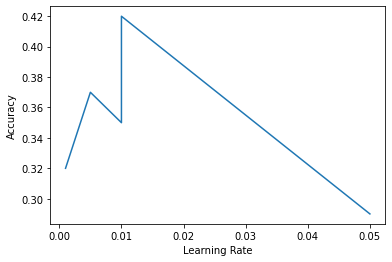

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
X=[0.001 ,0.005,0.01,0.01,0.05 ]
Y=[0.32,0.37,0.35,0.42,0.29]
plt.plot(X,Y)
plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')
plt.show()

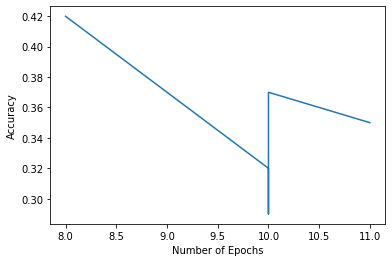

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
X=[8,10,10,10,11 ]
Y=[0.42,0.32,0.29,0.37,0.35]
plt.plot(X,Y)
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.show()

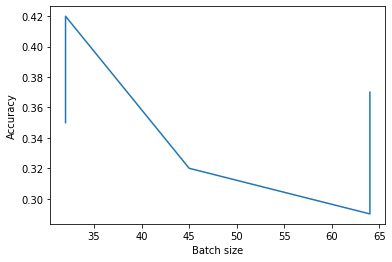

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
X=[32,32,45,64,64 ]
Y=[0.35,0.42,0.32,0.29,0.37]
plt.plot(X,Y)
plt.ylabel('Accuracy')
plt.xlabel('Batch size')
plt.show()